<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/heat_equation_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heat equation

## Problem setup

We will solve a heat equation:
$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \quad x \in [0, 1], \quad t \in [0, 1],
$$
where $\alpha = 0.4$ is the thermal diffusivity constant.

With Dirichlet boundary conditions:
$$
u(0, t) = u(1, t) = 0,
$$
and periodic (sinusoidal) initial condition:
$$
u(x, 0) = \sin\left(\frac{n \pi x}{L}\right), \quad 0 < x < L, \quad n = 1, 2, \ldots
$$
where \(L = 1\) is the length of the bar, \(n = 1\) is the frequency of the sinusoidal initial conditions.

The exact solution is:
$$
u(x, t) = e^{-\frac{n^2 \pi^2 \alpha t}{L^2}} \sin\left(\frac{n \pi x}{L}\right).
$$

## Implementation

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Define the 1D Heat equation PDE components
def heat_pde_residual(model, x, t, alpha):
    """
    Compute the PDE residual for heat equation:
    ∂u/∂t - α∂²u/∂x² = 0
    """
    x.requires_grad = True
    t.requires_grad = True
    u = model(torch.cat((x, t), dim=1))

    # Gradients w.r.t. x and t
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Second-order derivative w.r.t. x
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # PDE residual: ∂u/∂t + u∂u/∂x - ν∂²u/∂x²
    residual = u_t - alpha * u_xx
    return residual

# Step 2: Define the PINN model
class PINN(nn.Module):
    """Physics-Informed Neural Network for heat equation."""
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 50),  # Inputs: (x, t)
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: u(x, t)
        )

    def forward(self, x):
        return self.hidden_layers(x)

# Step 3: Define the loss function
def compute_loss(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, alpha):
    """Compute the combined loss for the PDE residual, boundary, and initial conditions."""
    # PDE residual loss
    residual = heat_pde_residual(model, x_interior, t_interior, alpha)
    pde_loss = torch.mean(residual**2)

    # Boundary condition loss: u(0, t) = 0 and u(1, t) = 0
    u_boundary_left = model(torch.cat((x_boundary[0], t_boundary), dim=1))
    u_boundary_right = model(torch.cat((x_boundary[1], t_boundary), dim=1))
    bc_loss = torch.mean(u_boundary_left**2) + torch.mean(u_boundary_right**2)

    # Initial condition loss: u(x, 0) = sin(πx)
    u_initial_pred = model(torch.cat((x_initial, t_initial), dim=1))
    ic_loss = torch.mean((u_initial_pred - u_initial)**2)

    return pde_loss + bc_loss + ic_loss

# Step 4: Training the model
def train_pinn(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial,
               alpha, adam_epochs=1000, lbfgs_epochs=500):
    """Train the PINN model using Adam and LBFGS optimizers."""
    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, alpha)
        loss.backward()
        optimizer_adam.step()
        if epoch % 100 == 0:
            print(f"Adam Epoch {epoch}, Loss: {loss.item()}")

    # LBFGS optimizer for fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=lbfgs_epochs, tolerance_grad=1e-7, tolerance_change=1e-9)

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, alpha)
        loss.backward()
        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)

In [ ]:
# Step 5: Generate training data
# Domain: x ∈ [0, 1], t ∈ [0, 1]
alpha = 0.04 # The thermal diffusivity constant
x = torch.linspace(0, 1, 100).view(-1, 1)
t = torch.linspace(0, 1, 100).view(-1, 1)

# Create mesh grid for interior points
x_grid, t_grid = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
x_interior = x_grid.flatten().view(-1, 1)
t_interior = t_grid.flatten().view(-1, 1)

# Boundary points
x_boundary = [torch.full_like(t, 0), torch.full_like(t, 1)]
t_boundary = t

# Initial points
x_initial = x
t_initial = torch.zeros_like(x)
u_initial = torch.sin(np.pi * x)

In [ ]:
# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, alpha,
           adam_epochs=1000, lbfgs_epochs=500)

Adam Epoch 0, Loss: 0.7042223811149597
Adam Epoch 100, Loss: 0.29544591903686523
Adam Epoch 200, Loss: 0.00530548021197319
Adam Epoch 300, Loss: 0.0022287103347480297
Adam Epoch 400, Loss: 0.0011067873565480113
Adam Epoch 500, Loss: 0.0005541119608096778
Adam Epoch 600, Loss: 0.00029415907920338213
Adam Epoch 700, Loss: 0.00016250934277195483
Adam Epoch 800, Loss: 8.65506153786555e-05
Adam Epoch 900, Loss: 4.898270344710909e-05
Starting LBFGS optimization...


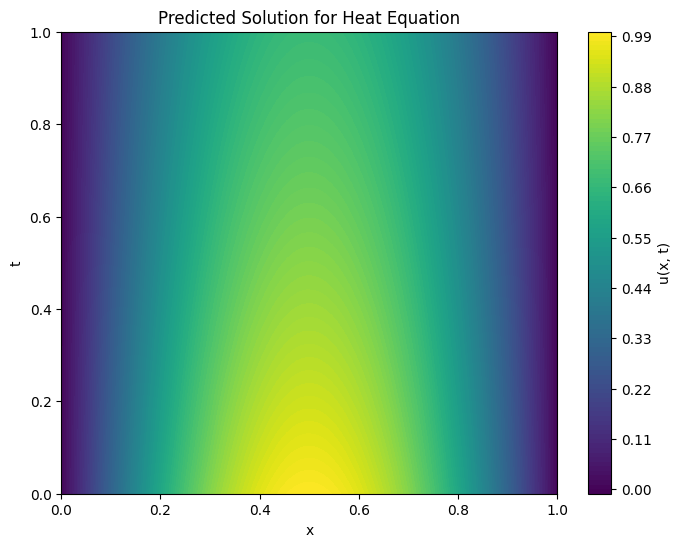

In [ ]:
# Step 7: Visualize the results
# Create a grid for prediction
x_pred = torch.linspace(0, 1, 100).view(-1, 1)
t_pred = torch.linspace(0, 1, 100).view(-1, 1)

x_grid_pred, t_grid_pred = torch.meshgrid(x_pred.squeeze(), t_pred.squeeze(), indexing='ij')
x_flat = x_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)

# Predict using the trained model
u_pred = model(torch.cat((x_flat, t_flat), dim=1)).detach().numpy()
u_pred = u_pred.reshape(100, 100)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.contourf(x_grid_pred.numpy(), t_grid_pred.numpy(), u_pred, levels=100, cmap='viridis')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted Solution for Heat Equation')
plt.show()


In [ ]:
# Exact solution
def u_exact_func(x, t):
    return torch.sin(np.pi * x) * torch.exp(-np.pi**2 * alpha * t)

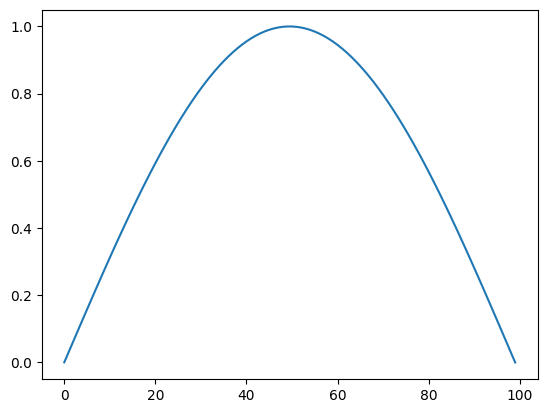

In [ ]:
plt.plot(u_pred[:,0])

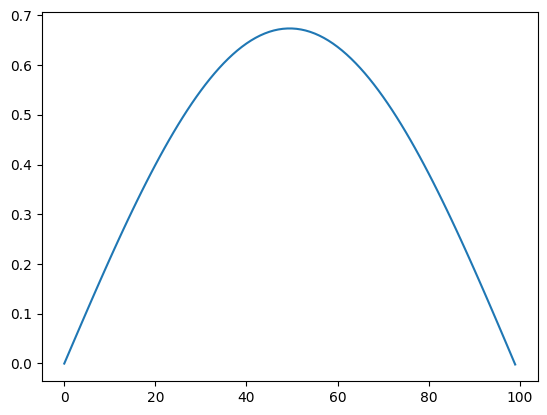

In [ ]:
plt.plot(u_pred[:,-1])

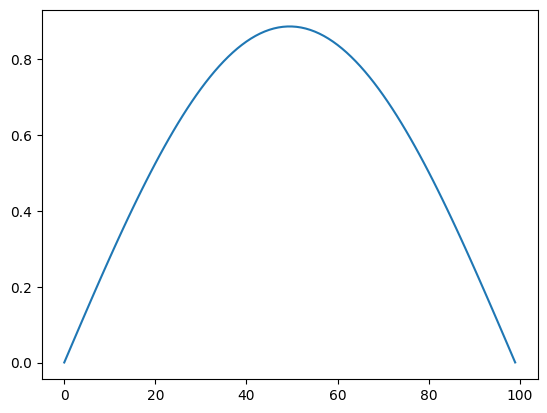

In [ ]:
plt.plot(u_pred[:,30])

In [ ]:
# u from exact function
u_exact = u_exact_func(x_flat, t_flat)
u_exact = u_pred.reshape(100, 100)

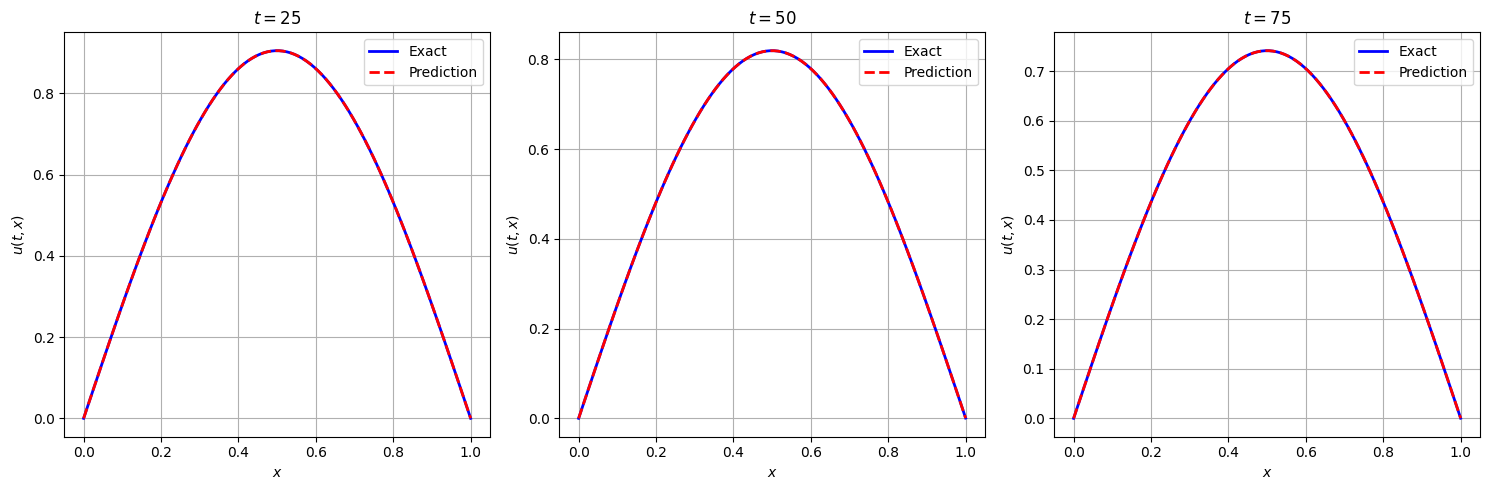

In [ ]:
# Step 8: Compare predictions with exact solution at specific time slices
time_slices = [25, 50, 75]  # Time slices to compare

plt.figure(figsize=(15, 5))

for i, t_slice in enumerate(time_slices):
    # Extract points for the time slice
    t_slice_tensor = torch.full_like(x_pred, t_slice)
    u_pred_slice = u_pred[:, t_slice]

    # Compute exact solution
    u_exact_slice = u_exact[:,t_slice]

    # Plot comparison
    plt.subplot(1, 3, i + 1)
    plt.plot(x.numpy(), u_exact_slice, 'b-', label='Exact', linewidth=2)
    plt.plot(x.numpy(), u_pred_slice, 'r--', label='Prediction', linewidth=2)
    plt.title(f"$t = {t_slice}$")
    plt.xlabel("$x$")
    plt.ylabel("$u(t, x)$")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


Adam Epoch 0, Loss: 0.8494189381599426
Adam Epoch 100, Loss: 0.2888105511665344
Adam Epoch 200, Loss: 0.004158071707934141
Adam Epoch 300, Loss: 0.0010599408997222781
Adam Epoch 400, Loss: 0.00037760354462079704
Adam Epoch 500, Loss: 0.00018040974100586027
Adam Epoch 600, Loss: 0.00010948844283120707
Adam Epoch 700, Loss: 7.472163997590542e-05
Adam Epoch 800, Loss: 5.3963292884873226e-05
Adam Epoch 900, Loss: 4.0674873162060976e-05
Starting LBFGS optimization...


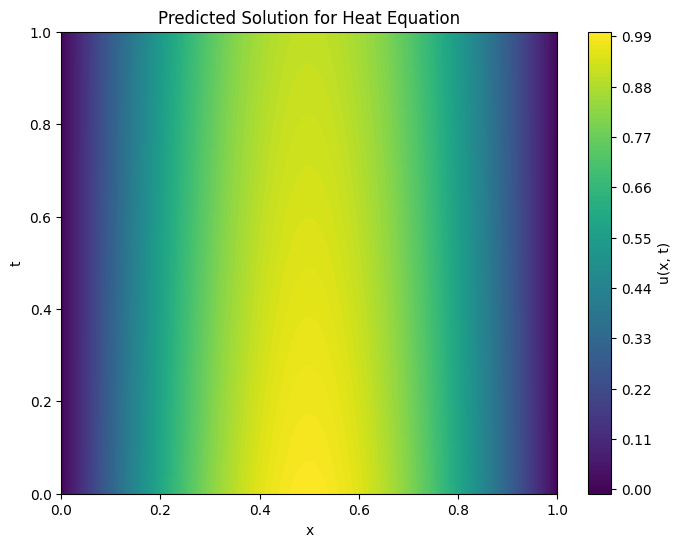

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the Heat Equation Residual
def heat_pde_residual(model, x, t, alpha):
    """
    Compute the PDE residual for the heat equation:
    ∂u/∂t - α∂²u/∂x² = 0
    """
    x.requires_grad = True
    t.requires_grad = True
    u = model(torch.cat((x, t), dim=1))

    # Gradients w.r.t. x and t
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Second-order derivative w.r.t. x
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # PDE residual: ∂u/∂t - α∂²u/∂x²
    residual = u_t - alpha * u_xx
    return residual

# Step 2: Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.hidden_layers(x)

# Step 3: Define the loss function
def compute_loss(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, alpha):
    # PDE residual loss
    residual = heat_pde_residual(model, x_interior, t_interior, alpha)
    pde_loss = torch.mean(residual**2)

    # Boundary condition loss
    u_boundary_left = model(torch.cat((x_boundary[0], t_boundary), dim=1))
    u_boundary_right = model(torch.cat((x_boundary[1], t_boundary), dim=1))
    bc_loss = torch.mean(u_boundary_left**2) + torch.mean(u_boundary_right**2)

    # Initial condition loss
    u_initial_pred = model(torch.cat((x_initial, t_initial), dim=1))
    ic_loss = torch.mean((u_initial_pred - u_initial)**2)

    return pde_loss + bc_loss + ic_loss

# Step 4: Training the model
def train_pinn(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, alpha, adam_epochs=1000, lbfgs_epochs=500):
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, alpha)
        loss.backward()
        optimizer_adam.step()
        if epoch % 100 == 0:
            print(f"Adam Epoch {epoch}, Loss: {loss.item()}")

    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=lbfgs_epochs, tolerance_grad=1e-7, tolerance_change=1e-9)

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, alpha)
        loss.backward()
        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)

# Step 5: Generate training data
L = 1  # Length of the rod
alpha = 0.01  # Thermal diffusivity
x = torch.linspace(0, L, 100).view(-1, 1)
t = torch.linspace(0, 1, 100).view(-1, 1)

# Mesh grid for interior points
x_grid, t_grid = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
x_interior = x_grid.flatten().view(-1, 1)
t_interior = t_grid.flatten().view(-1, 1)

# Boundary points
x_boundary = [torch.zeros_like(t), torch.ones_like(t)]
t_boundary = t

# Initial points
x_initial = x
t_initial = torch.zeros_like(x)
u_initial = torch.sin(np.pi * x)

# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, alpha)

# Step 7: Visualization (optional)
# Create a grid for prediction
x_pred = torch.linspace(0, L, 100).view(-1, 1)
t_pred = torch.linspace(0, 1, 100).view(-1, 1)
x_grid_pred, t_grid_pred = torch.meshgrid(x_pred.squeeze(), t_pred.squeeze(), indexing='ij')
x_flat = x_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)

# Predict using the trained model
u_pred = model(torch.cat((x_flat, t_flat), dim=1)).detach().numpy()
u_pred = u_pred.reshape(100, 100)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.contourf(x_grid_pred.numpy(), t_grid_pred.numpy(), u_pred, levels=100, cmap='viridis')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted Solution for Heat Equation')
plt.show()
